In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Sun Dec 10 16:17:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                            

In [2]:
!pip install transformers
!pip install farasapy==0.0.14
!pip install pyarabic==0.6.14
!git clone https://github.com/aub-mind/arabert
!pip install emoji==1.6.1
!pip install sentencepiece==0.1.96

fatal: destination path 'arabert' already exists and is not an empty directory.


###Creating training datasets

In [3]:
import pandas as pd
import numpy as np
from typing import List
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

This custom dataset class will help us hold our datasets in a structred manner

In [4]:
class CustomDataset:
    def __init__(
        self,
        name: str,
        train: List[pd.DataFrame],
        test: List[pd.DataFrame],
        label_list: List[str],
    ):
        """Class to hold and structure datasets.

        Args:

        name (str): holds the name of the dataset so we can select it later
        train (List[pd.DataFrame]): holds training pandas dataframe with 2 columns ["text","label"]
        test (List[pd.DataFrame]): holds testing pandas dataframe with 2 columns ["text","label"]
        label_list (List[str]): holds the list  of labels
        """
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [5]:
# This will hold all the downloaded and structred datasets
all_datasets= []
DATA_COLUMN = "text"
LABEL_COLUMN = "label"

### My Datasets

1. balanced_dataset_synonom

In [6]:
df_Offensive = pd.read_csv("/content/balanced_dataset_synonom_colab.csv", header=0)
ID=0
df_Offensive.columns = [ID, DATA_COLUMN, LABEL_COLUMN]

train_Offensive, test_Offensive = train_test_split(df_Offensive, test_size=0.2, random_state=42)

label_list_Offensive = list(df_Offensive[LABEL_COLUMN].unique())
print(label_list_Offensive)
print(df_Offensive[LABEL_COLUMN].value_counts())
data_Offensive_synonom = CustomDataset( "synonom_dataset", train_Offensive, test_Offensive, label_list_Offensive)
all_datasets.append(data_Offensive_synonom)

['A', 'B']
A    17509
B    17509
Name: label, dtype: int64


2. Balanced_AandBClasses_Oversampled_Revised

In [7]:

df_Offensive = pd.read_csv("/content/Balanced_AandBClasses_Oversampled_Revised.csv", header=0)
ID=0
df_Offensive.columns = [ID, DATA_COLUMN, LABEL_COLUMN]

train_Offensive, test_Offensive = train_test_split(df_Offensive, test_size=0.2, random_state=42)

label_list_Offensive = list(df_Offensive[LABEL_COLUMN].unique())
print(label_list_Offensive)
print(df_Offensive[LABEL_COLUMN].value_counts())
data_Offensive_Oversampled = CustomDataset( "Oversampled_dataset", train_Offensive, test_Offensive, label_list_Offensive)
all_datasets.append(data_Offensive_Oversampled)

['B', 'A']
B    7008
A    7008
Name: label, dtype: int64


3. SDOffensive_Agu_Shuffled:
Trying Augmented Data Using Shuffling.

In [8]:
df_Offensive = pd.read_csv(
    "/content/SDOffensive_Aug_Shuffled.csv", header=0
)
ID=0
df_Offensive.columns = [ID, DATA_COLUMN, LABEL_COLUMN]

train_Offensive, test_Offensive = train_test_split(
    df_Offensive, test_size=0.2, random_state=42
)

label_list_Offensive = list(df_Offensive[LABEL_COLUMN].unique())
print(label_list_Offensive)
print(df_Offensive[LABEL_COLUMN].value_counts())

data_Offensive_Shuffled = CustomDataset(
    "Offensive-Shuffled", train_Offensive, test_Offensive, label_list_Offensive
)

all_datasets.append(data_Offensive_Shuffled)

['Non-Offensive', 'Offensive']
Non-Offensive    17509
Offensive        14016
Name: label, dtype: int64


4. SDOffensive_Augmented_GPT2: Trying Augmented data Using GPT-2

In [9]:
df_Offensive = pd.read_csv(
    "/content/SDOffensive_Augmented_GPT2.csv", header=0
)
ID=0
df_Offensive.columns = [ID, DATA_COLUMN, LABEL_COLUMN]

train_Offensive, test_Offensive = train_test_split(
    df_Offensive, test_size=0.2, random_state=42
)

label_list_Offensive = list(df_Offensive[LABEL_COLUMN].unique())
print(label_list_Offensive)
print(df_Offensive[LABEL_COLUMN].value_counts())

data_Offensive_Augmented_GPT2 = CustomDataset(
    "Offensive-GPT-2", train_Offensive, test_Offensive, label_list_Offensive
)

all_datasets.append(data_Offensive_Augmented_GPT2)

['Non-Offensive', 'Offensive']
Non-Offensive    17509
Offensive        14016
Name: label, dtype: int64


###List all the datasets we have

In [10]:
for x in all_datasets:
  print(x.name)

synonom_dataset
Oversampled_dataset
Offensive-Shuffled
Offensive-GPT-2


#Trainer
Start the training procedure


In [11]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import copy

from arabert.preprocess import ArabertPreprocessor
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertTokenizer, Trainer,
                          TrainingArguments)
from transformers.data.processors.utils import InputFeatures

In [12]:
# select a dataset
dataset_name = 'synonom_dataset'
# select a model from the huggingface modelhub https://huggingface.co/models?language=ar
model_name = 'aubmindlab/bert-base-arabertv02-twitter' # we are going to use the twitter AraBERT since it has emojis and dialects

In [13]:
for d in all_datasets:
  if d.name==dataset_name:
    selected_dataset = copy.deepcopy(d)
    print('Dataset found')
    break

Dataset found


- Create and apply preprocessing using the AraBERT processor

In [14]:
arabic_prep = ArabertPreprocessor(model_name)

selected_dataset.train[DATA_COLUMN] = selected_dataset.train[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))
selected_dataset.test[DATA_COLUMN] = selected_dataset.test[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))

In [15]:
# Sanity check on the dataset
list(selected_dataset.train[DATA_COLUMN][0:10])

['USER USER عندهم القاب بولندا م عندها',
 '# كلنا _ معك _ يالسومهNLتعال # الاتحاد واترك # الأهلي ترا مامعاهم الا 3 دوريNL0 آسياNLولا بطولة خارجية تذكرNLعدنان فلاته بتاريخ الأهلي 😂 NLاللاعب وش يهمة غير الإنجازاتNLتعال يارجال عند جمهور الإتحاد العظيمNLUSER URL',
 'لافاز # الاهلي تنام الأرض مبسوطهNLالعشب سر إبتسامتها وفرحتهاNLNLالله يرحمك يامساعد الرشيدي URL',
 'وقت الاختبار بيخلص والدكتوره ماشرفت 😡',
 'USER يرحم امك تكفى رح ل اداره النادي قلهم انا حمار م اعرف العب والله مابها شي الله ياخذك',
 'USER انتبه من النسوان هه كل ماكثروا زادت الهموم 😂 😂 💔 الله يوفقك 💜 🤲 🏻',
 'ماديسون مكان هندرسون ي خنزير',
 'للاسف ناس قاعد تدور الشهرة على حساب غيرها ! ! 💩 💩',
 'يالييل الكذابه الثانييه مساففره وتكتب عن الوططن 👿 👿',
 'USER USER اذا هذا 70 الف بالساعة اجل الفنانيين الثانيين اللي اقدم منه وأشهر منه كم يستلمون بالساعة مليون ريال 🤬 😠 😡 🥵']

-
Now we need to check the tokenized sentence length to decide on the maximum sentence length value

In [16]:
tok = AutoTokenizer.from_pretrained(model_name)

Training Sentence Lengths: 


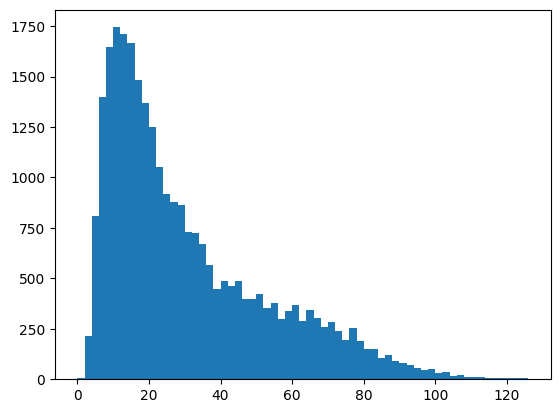

Testing Sentence Lengths: 


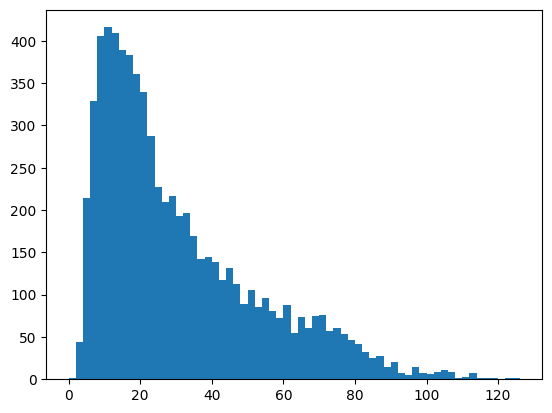

In [17]:
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.train[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.test[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

- Let's select 100 as our maximum sentence length, and check how many sequences will be truncated

In [18]:
max_len = 128

In [19]:
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]))

print("Truncated testing sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]))

Truncated training sequences:  1
Truncated testing sequences:  1


Good // I will explain here what is this process using GPT-4 support. as we will miss 0 data! so, no data will be deleted

- Now let's create a classification dataset to load the data

In [20]:
class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(ClassificationDataset).__init__()
      """
      Args:
      text (List[str]): List of the training text
      target (List[str]): List of the training labels
      tokenizer_name (str): The tokenizer name (same as model_name).
      max_len (int): Maximum sentence length
      label_map (Dict[str,int]): A dictionary that maps the class labels to integer
      """
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map


    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())

      inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
      )
      return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [21]:
label_map = { v:index for index, v in enumerate(selected_dataset.label_list) }
print(label_map)

train_dataset = ClassificationDataset(
    selected_dataset.train[DATA_COLUMN].to_list(),
    selected_dataset.train[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )
test_dataset = ClassificationDataset(
    selected_dataset.test[DATA_COLUMN].to_list(),
    selected_dataset.test[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )

{'A': 0, 'B': 1}


- Check the dataset output

In [22]:
print(next(iter(train_dataset)))

InputFeatures(input_ids=[2, 46160, 33573, 46160, 33573, 19345, 7008, 14783, 136, 10543, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

- Create a function that return a pretrained model ready to do classification


In [23]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

- Define whatever metric you want here:

In [24]:
'''
def compute_metrics(p): #p should be of type EvalPrediction
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)
  #print(classification_report(p.label_ids,preds))
  #print(confusion_matrix(p.label_ids,preds))
  macro_f1 = f1_score(p.label_ids,preds,average='macro')
  #macro_precision = precision_score(p.label_ids,preds,average='macro')
  #macro_recall = recall_score(p.label_ids,preds,average='macro')
  acc = accuracy_score(p.label_ids,preds)
  return {
      'macro_f1' : macro_f1,
      'accuracy': acc
  }
  '''

"\ndef compute_metrics(p): #p should be of type EvalPrediction\n  preds = np.argmax(p.predictions, axis=1)\n  assert len(preds) == len(p.label_ids)\n  #print(classification_report(p.label_ids,preds))\n  #print(confusion_matrix(p.label_ids,preds))\n  macro_f1 = f1_score(p.label_ids,preds,average='macro')\n  #macro_precision = precision_score(p.label_ids,preds,average='macro')\n  #macro_recall = recall_score(p.label_ids,preds,average='macro')\n  acc = accuracy_score(p.label_ids,preds)\n  return {\n      'macro_f1' : macro_f1,\n      'accuracy': acc\n  }\n  "

In [25]:
#----- From My Thoughts @_@

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)

    macro_F1 = f1_score(p.label_ids, preds, average='macro')
    micro_F1 = f1_score(p.label_ids, preds, average='micro')
    weighted_F1 = f1_score(p.label_ids, preds, average='weighted')

    macro_precision = precision_score(p.label_ids, preds, average='macro')
    macro_recall = recall_score(p.label_ids, preds, average='macro')

    micro_precision = precision_score(p.label_ids, preds, average='micro')
    micro_recall = recall_score(p.label_ids, preds, average='micro')

    weighted_precision = precision_score(p.label_ids, preds, average='weighted')
    weighted_recall = recall_score(p.label_ids, preds, average='weighted')

    acc = accuracy_score(p.label_ids, preds)

    return {
        'accuracy': acc,
        'Precision_macro': macro_precision,
        'Recall_macro': macro_recall,
        'macro_f1': macro_F1,

        'Precision_micro': micro_precision,
        'Recall_micro': micro_recall,
        'F1_micro': micro_F1,

        'Precision_weighted': weighted_precision,
        'Recall_weighted': weighted_recall,
        'F1_weighted': weighted_F1
    }

###Lets Do the follwing Classification Report to match my work on other classfiers:

In [26]:
'''
from sklearn.metrics import classification_report

def compute_metrics(p): #p should be of type EvalPrediction
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)

    # Get unique labels from both true and predicted labels
    unique_labels = np.unique(np.concatenate((p.label_ids, preds)))

    report = classification_report(p.label_ids, preds, labels=unique_labels, output_dict=True)

    metrics = {
        'accuracy': accuracy_score(p.label_ids, preds),
        'precision_non_offensive': report['Non-Offensive']['precision'],
        'recall_non_offensive': report['Non-Offensive']['recall'],
        'f1_non_offensive': report['Non-Offensive']['f1-score'],
        'precision_offensive': report['Offensive']['precision'],
        'recall_offensive': report['Offensive']['recall'],
        'f1_offensive': report['Offensive']['f1-score'],
        'macro_avg_precision': report['macro avg']['precision'],
        'macro_avg_recall': report['macro avg']['recall'],
        'macro_avg_f1': report['macro avg']['f1-score'],
        'weighted_avg_precision': report['weighted avg']['precision'],
        'weighted_avg_recall': report['weighted avg']['recall'],
        'weighted_avg_f1': report['weighted avg']['f1-score'],
    }
    return metrics
'''

"\nfrom sklearn.metrics import classification_report\n\ndef compute_metrics(p): #p should be of type EvalPrediction\n    preds = np.argmax(p.predictions, axis=1)\n    assert len(preds) == len(p.label_ids)\n\n    # Get unique labels from both true and predicted labels\n    unique_labels = np.unique(np.concatenate((p.label_ids, preds)))\n\n    report = classification_report(p.label_ids, preds, labels=unique_labels, output_dict=True)\n\n    metrics = {\n        'accuracy': accuracy_score(p.label_ids, preds),\n        'precision_non_offensive': report['Non-Offensive']['precision'],\n        'recall_non_offensive': report['Non-Offensive']['recall'],\n        'f1_non_offensive': report['Non-Offensive']['f1-score'],\n        'precision_offensive': report['Offensive']['precision'],\n        'recall_offensive': report['Offensive']['recall'],\n        'f1_offensive': report['Offensive']['f1-score'],\n        'macro_avg_precision': report['macro avg']['precision'],\n        'macro_avg_recall': re

In [27]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark = False

# K-fold Training:

This section is bit more advanced.

We will divide the training set into K-folds and train model with cross-validation to check for the best hyper-parameters before check the performance on the test set.

Alternatively, you can combine the training and testing set if you are participating in a competition, then ensemble the output models

In [28]:
# do kfold on the training. Check the perfomance on the test set
kfold_dataset = selected_dataset.train
# do kfold on all the dataset. Here we will not have any dataset to checl final performance on (this is used mainly in competitions)
# kfold_dataset = pd.concat([selected_dataset.train,selected_dataset.test])
kfold_dataset.reset_index(inplace=True,drop=True)

In [29]:
# this is used later
inv_label_map = { v:k for k, v in label_map.items()}

- Defing the number of Stratified kfold splits

In [30]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=123
  )

- Train using cross validation and save the best model at each fold

In [31]:
!pip install transformers[torch]
!pip install transformers
!pip install accelerate -U
!pip install accelerate>=0.20.1

In [32]:
!pip install transformers[torch] accelerate -U


In [33]:
! pip show transformers

Name: transformers
Version: 4.35.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 


In [34]:
! pip show accelerate

Name: accelerate
Version: 0.25.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: sylvain@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [35]:
!pip install torch torchvision


In [36]:
! pip show torch torchvision


Name: torch
Version: 2.1.0+cu118
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, triton, typing-extensions
Required-by: accelerate, fastai, torchaudio, torchdata, torchtext, torchvision
---
Name: torchvision
Version: 0.16.0+cu118
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, pillow, requests, torch
Required-by: fastai


In [37]:
from transformers import TrainingArguments, Trainer
import torch


In [38]:
!pip install transformers[torch]
!pip install accelerate --upgrade


In [ ]:

all_results = []
fold_best_f1 = 0
best_fold = None

for fold_num , (train, dev) in enumerate(kf.split(kfold_dataset,kfold_dataset['label'])):
  print("**************************Starting Fold Num: ", fold_num," **************************")

  train_dataset = ClassificationDataset(list(kfold_dataset[DATA_COLUMN][train]),
                              list(kfold_dataset[LABEL_COLUMN][train]),
                              model_name,
                              max_len,
                              label_map)

  val_dataset = ClassificationDataset(list(kfold_dataset[DATA_COLUMN][dev]),
                              list(kfold_dataset[LABEL_COLUMN][dev]),
                              model_name,
                              max_len,
                              label_map)

  training_args = TrainingArguments(
    output_dir= f"./train_{fold_num}",
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2,
    num_train_epochs= 2,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 123
  )

  set_seed(training_args.seed)

  trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
  )
  trainer.model.config.label2id = label_map
  trainer.model.config.id2label = inv_label_map

  trainer.train()

  results = trainer.evaluate()
  all_results.append(results)
  print(results)

  trainer.save_model(f"./train_{fold_num}/best_model")
  val_dataset.tokenizer.save_pretrained(f"./train_{fold_num}/best_model")

  # delete the rest of the checkpoints
  !rm -rf f"./train_{fold_num}/checkpoint-*"

  if results['eval_macro_f1'] > fold_best_f1:
    print('**************************New Best Model Found!**************************')
    fold_best_f1 = results['eval_macro_f1']
    best_fold = fold_num

**************************Starting Fold Num:  0  **************************


config.json:   0%|          | 0.00/667 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.weight', 'classifier.bias', 'bert.pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,Macro F1,Precision Micro,Recall Micro,F1 Micro,Precision Weighted,Recall Weighted,F1 Weighted
0,No log,0.270762,0.881492,0.881558,0.881486,0.881486,0.881492,0.881492,0.881492,0.881554,0.881492,0.881486


In [ ]:
from statistics import mean
mean([x['eval_macro_f1'] for x in all_results])

# Ensemble all the cross validation models:

In [ ]:
from transformers import pipeline
import more_itertools

In [ ]:
inv_label_map = { v:k for k, v in label_map.items()}

In [ ]:
# pred_df = prediction['Text']
# pred_df = pred_df.apply(lambda x:   arabic_prep.preprocess(x))

pred_df = selected_dataset.test[DATA_COLUMN]

In [ ]:
cross_val_df = pd.DataFrame([])
for i in range(0,5):
  pipe = pipeline("sentiment-analysis", model=f"train_{i}/best_model", device=0, return_all_scores =True, max_length=max_len, truncation=True)
  preds = []
  for s in tqdm(more_itertools.chunked(list(pred_df), 32)): # batching for faster inference
    preds.extend(pipe(s))
  cross_val_df[f'model_{i}'] = preds

In [ ]:
from collections import defaultdict

final_labels = []
final_scores = []
for id, row in cross_val_df.iterrows():
  total_score = defaultdict(lambda: 0)
  for pred in row:
    for cls in pred:
      total_score[cls['label']] += cls['score']

  avg_score = { k: v/ 5 for k, v in total_score.items()}

  final_labels.append(max(avg_score, key=avg_score.get))
  final_scores.append(avg_score[max(avg_score, key=avg_score.get)])

In [ ]:
cross_val_df['preds'] = final_labels
cross_val_df['sentiment_score'] = final_scores

In [ ]:
cross_val_df['preds'].value_counts()

In [ ]:
print(classification_report(selected_dataset.test[LABEL_COLUMN],cross_val_df['preds']))

In [ ]:
# Get classification report in dictionary format
report = classification_report(selected_dataset.test[LABEL_COLUMN], cross_val_df['preds'], output_dict=True)

# Extract and print required metrics
precision = report['weighted avg']['precision']
precision_macro = report['macro avg']['precision']

recall = report['weighted avg']['recall']
recall_macro = report['macro avg']['recall']

f1 = report['weighted avg']['f1-score']
f1_macro = report['macro avg']['f1-score']
f1_micro = f1_score(selected_dataset.test[LABEL_COLUMN], cross_val_df['preds'], average='micro')

print("Classification Report:\n")
print(classification_report(selected_dataset.test[LABEL_COLUMN], cross_val_df['preds']))

print(f"\nPrecision (Weighted): {precision:.2f}")
print(f"Precision (Macro): {precision_macro:.2f}")
print(f"Recall (Weighted): {recall:.2f}")
print(f"Recall (Macro): {recall_macro:.2f}")
print(f"F1-Score (Weighted): {f1:.2f}")
print(f"F1-Score (Macro): {f1_macro:.2f}")
print(f"F1-Score (Micro): {f1_micro:.2f}")

